# Multi-Class Segmentation for Animal Parts**

Finetune a **pretrained U-Net** model for **multi-class segmentation** of animal parts. Segmentation model will classify each pixel into **one of 5 classes** (Tail, Body, Legs, Head, Background).


In [ ]:
import os

# # Set KaggleHub cache to a directory inside /content/
os.environ["KAGGLEHUB_CACHE"] = "/content/data"

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohammad2012191/segmentation")

print("Path to dataset files:", path)

Path to dataset files: /content/data/datasets/mohammad2012191/segmentation/versions/1


## Dataset Class**
- Build a custom dataset class to load images and masks.
- Prepare your train and validation dataloaders.
- Display some images and their corresponding masks.



In [ ]:
# Now let's see what's inside the dataset folder
dataset_path = "/content/data/datasets/mohammad2012191/segmentation/versions/1"
print("Files and Folders in Dataset Directory:", os.listdir(dataset_path))

# We need "train" and "val" folders, or else something is wrong
folders = os.listdir(dataset_path)
print("Dataset contains:", folders)

if "train" in folders and "val" in folders:
    train_image_dir, train_mask_dir = f"{dataset_path}/train/images", f"{dataset_path}/train/masks"
    val_image_dir, val_mask_dir = f"{dataset_path}/val/images", f"{dataset_path}/val/masks"
else:
    raise FileNotFoundError("FileNotFoundError :( ")

Files and Folders in Dataset Directory: ['val', 'train']
Dataset contains: ['val', 'train']


In [4]:
# Here, we're making a dataset class to load images and masks
# This is what PyTorch will use when training

from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class AnimalSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        # Get all image and mask file paths
        self.image_paths = sorted(Path(image_dir).glob("*.jpg"))
        self.mask_paths = sorted(Path(mask_dir).glob("*.png"))

        # If something's wrong and no images or masks exist, stop
        if not self.image_paths or not self.mask_paths:
            raise FileNotFoundError("No images or masks found. Check dataset structure!")

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)  # Just return how many images we have

    def __getitem__(self, idx):
        # Load the image and the corresponding mask
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[idx]))

        # If the mask has weird values, clip them (it should be between 0-4)
        mask = np.clip(mask, 0, 4)

        # Apply transformations if there are any (resizing, flipping, etc.)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            return augmented["image"], augmented["mask"]

        return image, mask  # If no transformations, just return as is


In [5]:
# These are the transformations applied to the images before training
# The training set has more transformations because we want some variation in images (Data Augmentation)

import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(256, 256),  # Resize everything to 256x256
    A.HorizontalFlip(p=0.5),  # Randomly flip some images
    A.RandomBrightnessContrast(p=0.2),  # Slightly adjust brightness/contrast
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Standard normalization
    ToTensorV2()  # Convert to PyTorch tensor
])

val_transform = A.Compose([
    A.Resize(256, 256),  # Just resizing, no other changes for validation
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Same normalization
    ToTensorV2()
])


In [6]:
# Now we actually load the datasets using the class we wrote

train_dataset = AnimalSegmentationDataset(train_image_dir, train_mask_dir, transform=train_transform)
val_dataset = AnimalSegmentationDataset(val_image_dir, val_mask_dir, transform=val_transform)

# We use DataLoader to batch and shuffle the data during training
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

# Quick check to see if the dataset loaded correctly
print(f"Train Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")

Train Samples: 1737
Validation Samples: 435


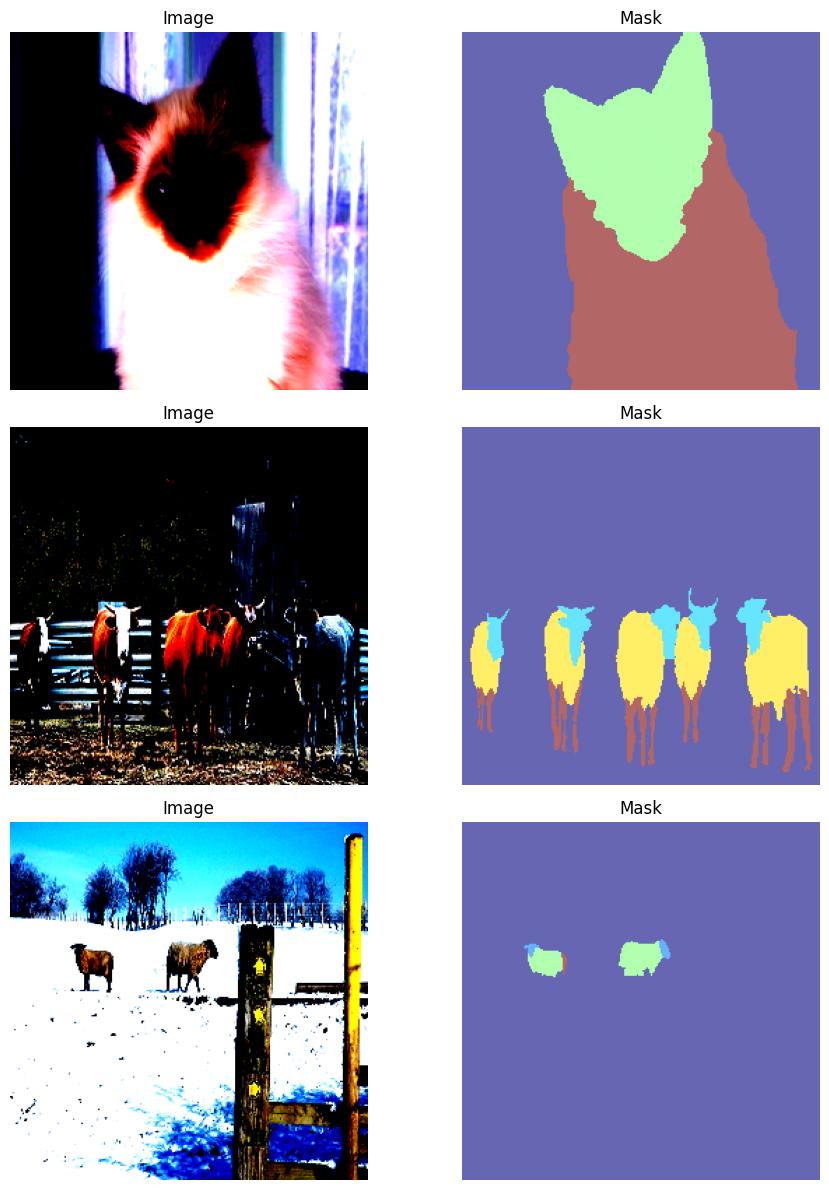

In [7]:
# Here we check if everything is working fine by displaying some images and their masks

import matplotlib.pyplot as plt
import random

def visualize_samples(dataset, num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 4))

    for i in range(num_samples):
        # Pick a random image from the dataset
        img, mask = dataset[random.randint(0, len(dataset) - 1)]

        # Convert tensor to a NumPy image
        img_np = img.permute(1, 2, 0).numpy()
        mask_np = mask.numpy()

        # Show the image
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title("Image")

        # Show the corresponding mask
        axes[i, 1].imshow(mask_np, cmap="jet", alpha=0.6)
        axes[i, 1].set_title("Mask")

        # Remove axis labels for a cleaner look
        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Run the function to check if everything is correct
visualize_samples(train_dataset)


## Model Class
- **Use a pretrained U-Net** (from `segmentation_models_pytorch`) with "efficientnet-b0" as an encoder.

In [ ]:
!pip install segmentation-models-pytorch

In [9]:
import torch.nn as nn
import segmentation_models_pytorch as smp

# Define the segmentation model using a U-Net architecture with EfficientNet-B0
class UNetSegmentation(nn.Module):
    def __init__(self, num_classes=5, encoder="efficientnet-b0", pretrained=True):
        super(UNetSegmentation, self).__init__()

        self.model = smp.Unet(
            encoder_name=encoder,  # EfficientNet-B0 as the encoder
            encoder_weights="imagenet" if pretrained else None,  # Use pretrained weights
            in_channels=3,  # 3 bc RGB images
            classes=num_classes,  # 5 output classes (Tail, Body, Legs, Head, Background)
        )

    def forward(self, x):
        return self.model(x)

model = UNetSegmentation(num_classes=5)

## Training and Validation Loops

---


- Define the training and validation loops.

In [10]:
#got sooo many errrorssss cuz of the sizes
#there was two ways to fix it either go back and plat woth the data in task one or here and cast it so i did the easy one i think

In [ ]:
# training loop, updates weights
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device).long()  # was a painnnnnnnnnn had to make sure the masks are in long format

        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass

        loss = criterion(outputs, masks)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model weights

        running_loss += loss.item()

    return running_loss / len(dataloader)

# Validation loop, no weight updates
def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device).long() #same thng hereeeee

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    return val_loss / len(dataloader)


## Running Training
- Define the loss and the optimizer.
- Train the model for 10 epochs.
- Print the training and validation losses.
- Plot loss curve.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = UNetSegmentation(num_classes=5).to(device)

Using device: cuda


Epoch [1/10] - Train Loss: 0.8920 - Val Loss: 0.4992
Epoch [2/10] - Train Loss: 0.4641 - Val Loss: 0.3541
Epoch [3/10] - Train Loss: 0.3647 - Val Loss: 0.3185
Epoch [4/10] - Train Loss: 0.3163 - Val Loss: 0.2797
Epoch [5/10] - Train Loss: 0.2839 - Val Loss: 0.2671
Epoch [6/10] - Train Loss: 0.2481 - Val Loss: 0.2537
Epoch [7/10] - Train Loss: 0.2310 - Val Loss: 0.2403
Epoch [8/10] - Train Loss: 0.2211 - Val Loss: 0.2372
Epoch [9/10] - Train Loss: 0.2035 - Val Loss: 0.2360
Epoch [10/10] - Train Loss: 0.1980 - Val Loss: 0.2358


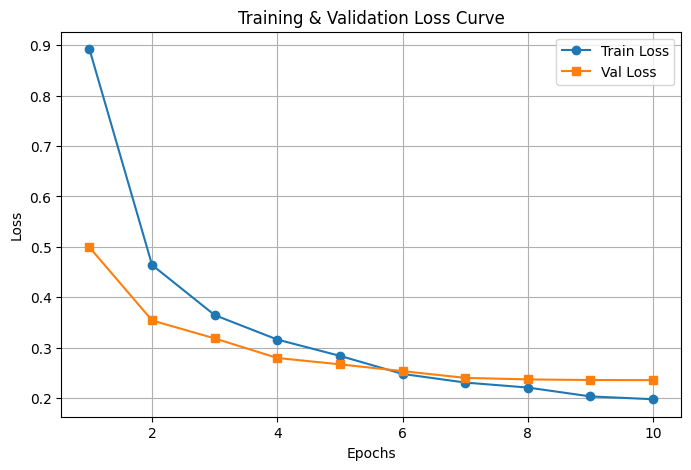

In [13]:
# Use the optimizer and loss function only (no need to re-import torch.optim or matplotlib)
import torch.optim as optim
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # our good old buudy adam the optimizer

num_epochs = 10
train_losses, val_losses = [], []

# our training loop that takes forever ~my fav Ai meme are about it
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

# seeing how things aregoing thats why we plot the loss curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss Curve")
plt.grid()
plt.show()


## Visualizing Predictions
- Visualize model's predictions against the ground truth for several images.

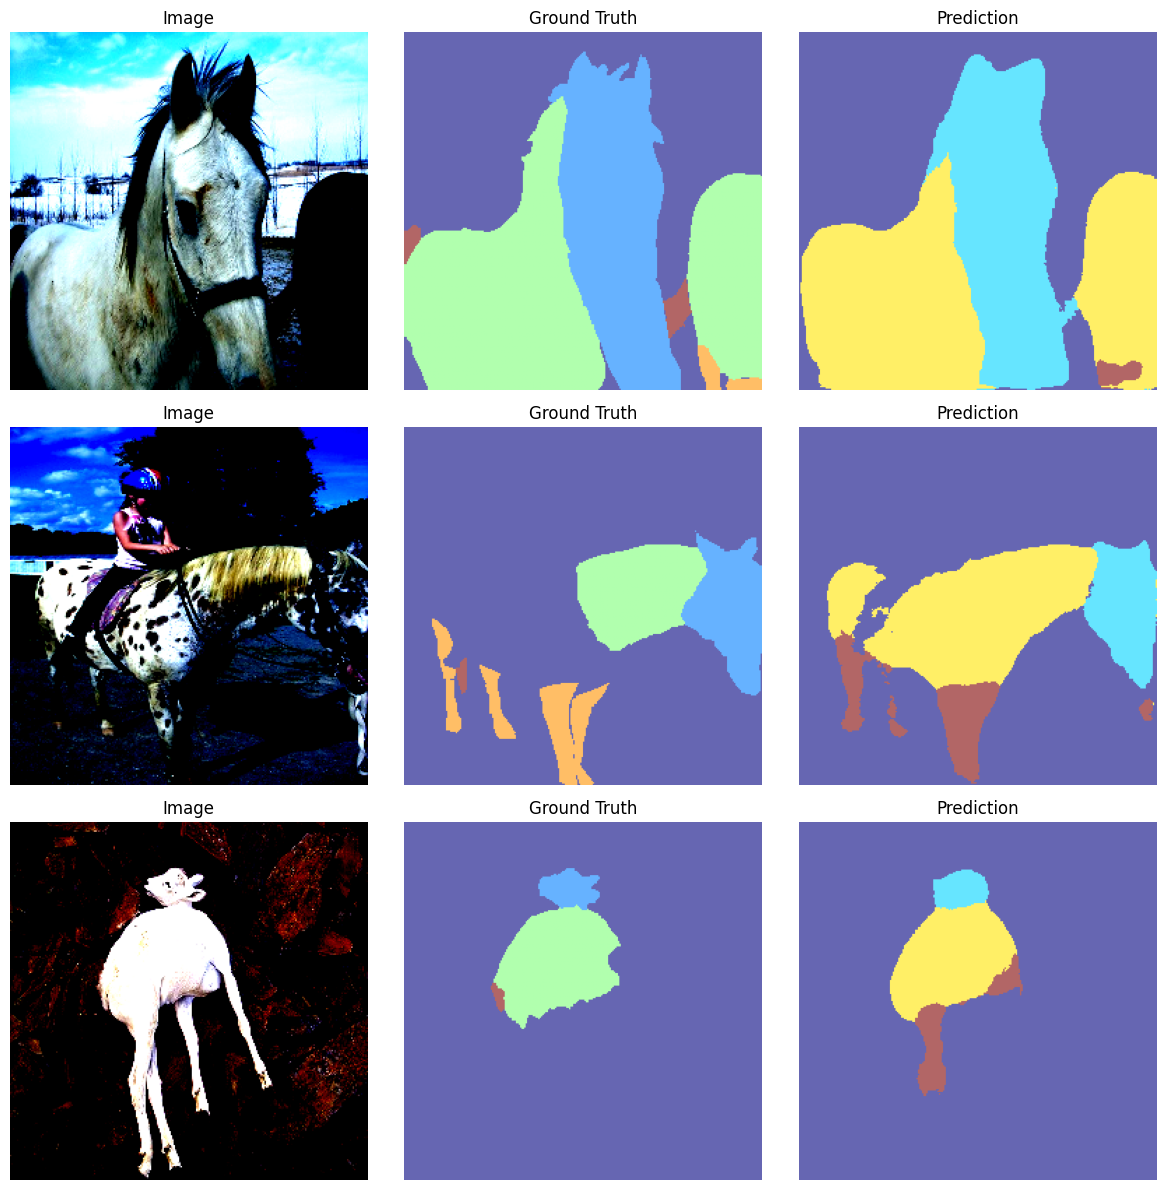

In [ ]:
def visualize_predictions(model, dataset, num_samples=3):
    model.eval()  # No training, just vibes
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)  # Randomly pick an image
        img, mask = dataset[idx]

        img = img.unsqueeze(0).to(device)  # Pretend it's a batch
        with torch.no_grad():  # No gradients, we’re just looking
            pred_mask = torch.argmax(model(img), dim=1).cpu().squeeze(0).numpy()

        img_np = img.cpu().squeeze(0).permute(1, 2, 0).numpy()
        mask_np = mask.numpy()

        # Original image
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title("Image")

        # The correct mask
        axes[i, 1].imshow(mask_np, cmap="jet", alpha=0.6)
        axes[i, 1].set_title("Ground Truth")

        # The model’s attempt
        axes[i, 2].imshow(pred_mask, cmap="jet", alpha=0.6)
        axes[i, 2].set_title("Prediction")

        # No ugly axes
        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Let’s see if this thing actually works
visualize_predictions(model, val_dataset)
